In [2]:
# Install required libraries for spectrogram analysis
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

# Install required packages
install_package("librosa")
install_package("matplotlib")
install_package("numpy")
install_package("scipy")

print("\n🎵 All audio analysis libraries ready!")

✅ librosa already installed
✅ matplotlib already installed
✅ numpy already installed
✅ scipy already installed

🎵 All audio analysis libraries ready!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import wave

# File paths for comparison
original = "0recording_near.wav"  # Original audio file
hidden_in = "stego_output.wav"    # Audio file with hidden data

def load_audio_data(file_path):
    """Load audio data using librosa for better compatibility"""
    try:
        # Load audio with librosa (handles various formats better)
        audio_data, sr = librosa.load(file_path, sr=None)
        return audio_data, sr
    except:
        # Fallback to wave module for WAV files
        with wave.open(file_path, 'rb') as wav_file:
            frames = wav_file.readframes(-1)
            sr = wav_file.getframerate()
            channels = wav_file.getnchannels()
            sampwidth = wav_file.getsampwidth()
            
            if sampwidth == 2:
                audio_data = np.frombuffer(frames, dtype=np.int16).astype(np.float32)
                audio_data = audio_data / 32768.0
            elif sampwidth == 1:
                audio_data = np.frombuffer(frames, dtype=np.uint8).astype(np.float32)
                audio_data = (audio_data - 128) / 128.0
            else:
                raise ValueError(f"Unsupported sample width: {sampwidth}")
            
            if channels == 2:
                audio_data = audio_data.reshape(-1, 2)
                audio_data = np.mean(audio_data, axis=1)
                
            return audio_data, sr

def generate_spectrograms(original_file, stego_file):
    """Generate and display spectrograms for original and stego audio files"""
    
    # Load audio files
    print("Loading audio files...")
    original_audio, sr1 = load_audio_data(original_file)
    stego_audio, sr2 = load_audio_data(stego_file)
    
    print(f"Original: {len(original_audio)} samples at {sr1} Hz")
    print(f"Stego: {len(stego_audio)} samples at {sr2} Hz")
    
    # Ensure same length for comparison
    min_length = min(len(original_audio), len(stego_audio))
    original_audio = original_audio[:min_length]
    stego_audio = stego_audio[:min_length]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original audio spectrogram
    D_orig = librosa.stft(original_audio)
    DB_orig = librosa.amplitude_to_db(np.abs(D_orig), ref=np.max)
    
    img1 = librosa.display.specshow(DB_orig, sr=sr1, x_axis='time', y_axis='hz', 
                                   ax=axes[0,0], cmap='viridis')
    axes[0,0].set_title('Original Audio Spectrogram')
    axes[0,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(img1, ax=axes[0,0], format='%+2.0f dB')
    
    # Stego audio spectrogram
    D_stego = librosa.stft(stego_audio)
    DB_stego = librosa.amplitude_to_db(np.abs(D_stego), ref=np.max)
    
    img2 = librosa.display.specshow(DB_stego, sr=sr2, x_axis='time', y_axis='hz', 
                                   ax=axes[0,1], cmap='viridis')
    axes[0,1].set_title('Stego Audio Spectrogram')
    axes[0,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(img2, ax=axes[0,1], format='%+2.0f dB')
    
    # Difference spectrogram
    diff_audio = stego_audio - original_audio
    D_diff = librosa.stft(diff_audio)
    DB_diff = librosa.amplitude_to_db(np.abs(D_diff), ref=np.max)
    
    img3 = librosa.display.specshow(DB_diff, sr=sr1, x_axis='time', y_axis='hz', 
                                   ax=axes[1,0], cmap='RdBu_r')
    axes[1,0].set_title('Difference Spectrogram (Stego - Original)')
    axes[1,0].set_ylabel('Frequency (Hz)')
    axes[1,0].set_xlabel('Time (s)')
    plt.colorbar(img3, ax=axes[1,0], format='%+2.0f dB')
    
    # Statistical comparison
    axes[1,1].axis('off')
    
    # Calculate statistics
    orig_power = np.mean(original_audio**2)
    stego_power = np.mean(stego_audio**2)
    diff_power = np.mean(diff_audio**2)
    snr = 10 * np.log10(orig_power / diff_power) if diff_power > 0 else float('inf')
    
    stats_text = f"""
    AUDIO STATISTICS:
    
    Original Power: {orig_power:.2e}
    Stego Power: {stego_power:.2e}
    Difference Power: {diff_power:.2e}
    
    Signal-to-Noise Ratio: {snr:.2f} dB
    
    Power Ratio: {(stego_power/orig_power - 1)*100:.4f}%
    
    Max Difference: {np.max(np.abs(diff_audio)):.6f}
    RMS Difference: {np.sqrt(np.mean(diff_audio**2)):.6f}
    
    Correlation: {np.corrcoef(original_audio, stego_audio)[0,1]:.6f}
    """
    
    axes[1,1].text(0.1, 0.9, stats_text, transform=axes[1,1].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'snr': snr,
        'correlation': np.corrcoef(original_audio, stego_audio)[0,1],
        'power_ratio': stego_power/orig_power,
        'max_diff': np.max(np.abs(diff_audio)),
        'rms_diff': np.sqrt(np.mean(diff_audio**2))
    }

🔍 Analyzing spectrograms...
📁 Original file: 0recording_near.wav
📁 Stego file: stego_output.wav
Loading audio files...
Original: 1440000 samples at 48000 Hz
Stego: 1440000 samples at 48000 Hz


ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

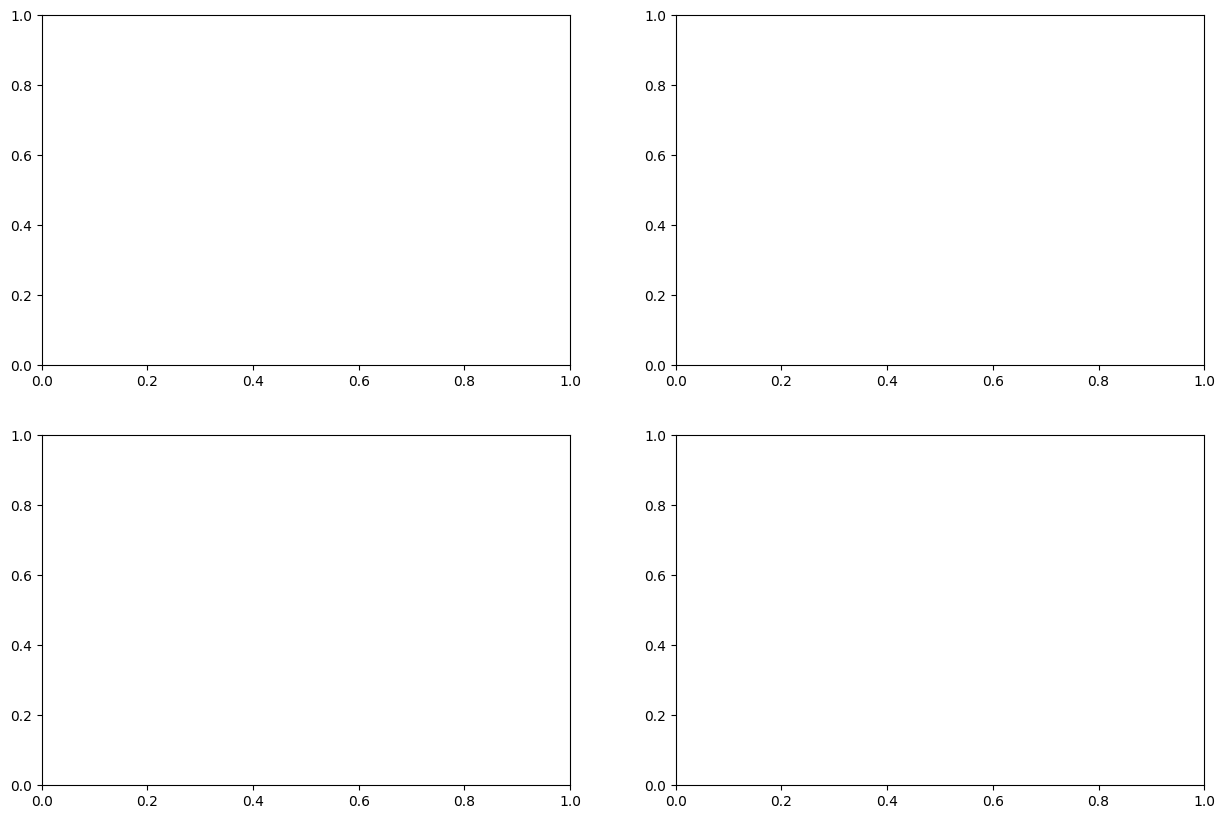

In [4]:
# Generate spectrograms and compare the files
print("🔍 Analyzing spectrograms...")
print(f"📁 Original file: {original}")
print(f"📁 Stego file: {hidden_in}")
print("="*50)

# Run the analysis
stats = generate_spectrograms(original, hidden_in)

print("\n📊 ANALYSIS SUMMARY:")
print(f"🔊 Signal-to-Noise Ratio: {stats['snr']:.2f} dB")
print(f"📈 Correlation: {stats['correlation']:.6f}")
print(f"⚡ Power Ratio: {stats['power_ratio']:.6f}")
print(f"📏 Max Difference: {stats['max_diff']:.6f}")
print(f"📐 RMS Difference: {stats['rms_diff']:.6f}")

# Interpretation
if stats['snr'] > 40:
    print("✅ Excellent steganography quality - differences barely detectable")
elif stats['snr'] > 30:
    print("✅ Good steganography quality - minimal audible differences")
elif stats['snr'] > 20:
    print("⚠️ Moderate quality - some differences may be noticeable")
else:
    print("❌ Poor quality - significant differences present")